In [ ]:
import numpy as np
import pandas as pd
import torch
import os, sys
sys.path.append(os.path.realpath('./src/'))

import time
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon, Ellipse
from smallestEllipse import *

from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder


import scipy as sp




In [4]:
def preprocessData():
    # Load your data
    df = pd.read_excel('./computed_material_features_to_use.xlsx')

    # Keep track of 'family' only
    dataIdentifier = {'family': df['family'],'classID':df[df.columns[9]]}

    # Select the properties you want to model (features)
    feature_columns = ['rho_eff', 'cost', 'energy', 'waste']
    trainInfo = np.log10(df[feature_columns].to_numpy())

    # Normalize to [0, 1]
    dataScaleMax = torch.tensor(np.max(trainInfo, axis=0))
    dataScaleMin = torch.tensor(np.min(trainInfo, axis=0))
    normalizedData = (torch.tensor(trainInfo) - dataScaleMin) / (dataScaleMax - dataScaleMin)
    trainingData = normalizedData.clone().float()

    # Create dataInfo for reference
    dataInfo = {
        'rho_eff': {'idx': 0, 'scaleMin': dataScaleMin[0], 'scaleMax': dataScaleMax[0]},
        'cost':    {'idx': 1, 'scaleMin': dataScaleMin[1], 'scaleMax': dataScaleMax[1]},
        'energy':  {'idx': 2, 'scaleMin': dataScaleMin[2], 'scaleMax': dataScaleMax[2]},
        'waste':   {'idx': 3, 'scaleMin': dataScaleMin[3], 'scaleMax': dataScaleMax[3]},
    }

    return trainingData, dataInfo, dataIdentifier, trainInfo

trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape


In [5]:
latentDim, hiddenDim = 2, 250
numEpochs = 4000
klFactor = 4.5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)
start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F} '.format(time.perf_counter() - start))

cpu
Iter 0 reconLoss 1.13E+03 klLoss 4.78E-01 loss 1.13E+03
Iter 500 reconLoss 9.68E+00 klLoss 2.73E+00 loss 1.24E+01
Iter 1000 reconLoss 9.03E+00 klLoss 2.41E+00 loss 1.14E+01
Iter 1500 reconLoss 8.84E+00 klLoss 2.28E+00 loss 1.11E+01
Iter 2000 reconLoss 8.52E+00 klLoss 2.21E+00 loss 1.07E+01
Iter 2500 reconLoss 8.47E+00 klLoss 2.18E+00 loss 1.06E+01
Iter 3000 reconLoss 8.35E+00 klLoss 2.15E+00 loss 1.05E+01
Iter 3500 reconLoss 8.17E+00 klLoss 2.13E+00 loss 1.03E+01
training time : 63.84 


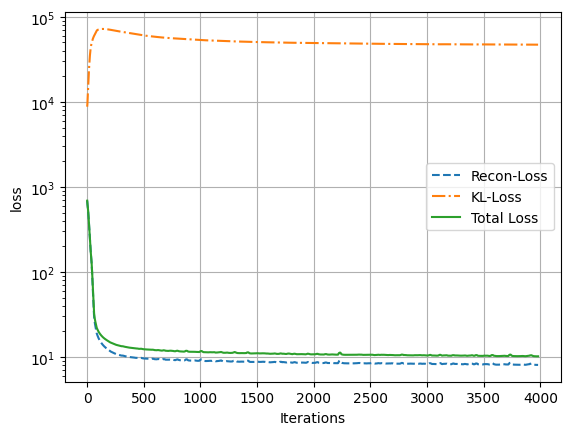

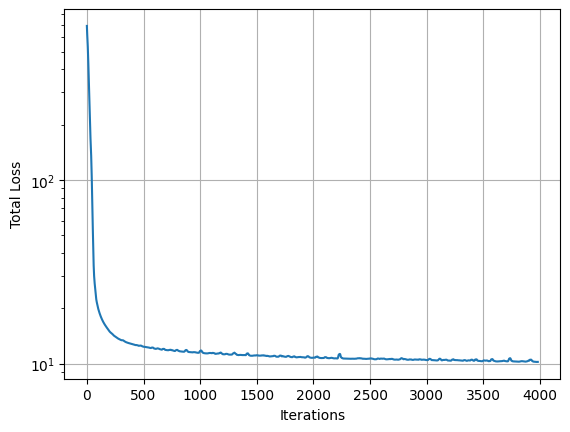

In [7]:
def plotConvergence(convg):
  plt.figure()
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    y = torch.as_tensor(convg[key]).detach().numpy()
    y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend(labels={'KL-Loss','Recon-Loss','Total Loss'})
    # plt.legend('ReconLoss','KL-Loss','TotalLoss')
    plt.savefig('./figures/convergence.pdf',bbox_inches='tight')

plotConvergence(convgHistory)


def plotLoss(convg):
  plt.figure()
  y = torch.as_tensor(convg['loss']).detach().numpy()
  y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
  plt.semilogy(y_mvavg, '-', label = 'Total Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Total Loss')
  plt.grid('True')
  # plt.legend(labels={'Total Loss'})

plotLoss(convgHistory)



In [19]:
def unnormalize(val, minval, maxval):
    return 10.**(minval + (maxval - minval) * val)

def decodeAll():
    vae = materialEncoder.vaeNet
    decoded = vae.decoder(vae.encoder.z)
    matProp = {}
    for k in props:
        idx = materialEncoder.dataInfo[k]['idx']
        scaleMax = materialEncoder.dataInfo[k]['scaleMax']
        scaleMin = materialEncoder.dataInfo[k]['scaleMin']
        matProp[k] = unnormalize(decoded[:, idx], scaleMin, scaleMax)
    return matProp

matProp = decodeAll()

print('\n----- Per-Material Reconstruction Table (First 10 Entries) -----\n')
header = f"{'Index':<5} {'Family':<20}"
for p in props:
    header += f"{p + ' (True)':>15} {p + ' (Recon)':>15} {p + ' %Err':>10}"
print(header)
print('-' * len(header))

maxError = {p: -1e10 for p in props}

# Limiting to the first 10 materials
num_entries_to_show = 10  # Change this to show more/less entries

for i in range(trainInfo.shape[0]):  # Only loop through the first 10 materials
    family = dataIdentifier['family'][i]
    row = f"{i:<5} {family:<20}"
    for p in props:
        idx = materialEncoder.dataInfo[p]['idx']
        true_val = 10**trainInfo[i, idx]
        recon_val = matProp[p][i].item()
        err_pct = abs(100 * (true_val - recon_val) / true_val)
        row += f"{true_val:15.3e} {recon_val:15.3e} {err_pct:10.2f}"

        # Update max error
        if err_pct > maxError[p]:
            maxError[p] = err_pct
    if i < num_entries_to_show:  # Only print the first 10 materials        
        print(row)

print('\n----- MAX Error per Property (%) -----')
for p in props:
    print(f"{p:<10}: {maxError[p]:.2f}")



----- Per-Material Reconstruction Table (First 10 Entries) -----

Index Family               rho_eff (True) rho_eff (Recon) rho_eff %Err    cost (True)    cost (Recon)  cost %Err  energy (True)  energy (Recon) energy %Err   waste (True)   waste (Recon) waste %Err
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0     CFRP                      2.429e+03       2.404e+03       1.02      1.258e+02       1.220e+02       2.99      2.075e+03       2.105e+03       1.45      6.811e-01       6.694e-01       1.72
1     Titanium                  3.523e+03       3.516e+03       0.19      1.122e+02       1.059e+02       5.60      2.425e+03       2.610e+03       7.59      7.232e-01       7.175e-01       0.78
2     CFRP                      2.736e+03       2.646e+03       3.27      8.564e+01       7.926e+01       7.45      1.155e+03       1.322e+03      

In [15]:
merr = torch.tensor([0.])
meanError = {'rho_eff':merr,'cost':merr,\
             'energy':merr,'waste':merr}

for i in range(trainInfo.shape[0]):
  # if(i in matidxs): #
  #   print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData).cpu()
    err = err.reshape((1,) + err.shape)
    meanError[p] = torch.cat((meanError[p],err),0)
    # meanError[p] = torch.cat([meanError[p],err],0)

print('\n \t -----Mean Error %----- \t ', end = '\n')
for p in props:
    print(p, end = '\t')
    print('\t {:.1F} \t'.format(torch.mean(meanError[p])), end='\n')


 	 -----Mean Error %----- 	 
rho_eff		 0.8 	
cost		 3.8 	
energy		 5.4 	
waste		 1.0 	


The following 2D latent space representation corresponds to the result of encoding our material properties with the "materialEncoder" (function with the trained VAE). 

Hulls will delimit each "material family" (i.e the points that share a larger composition a material among Aluminium Titanium, Steel and CFRP). 

The covariance ellipses describe the region within 1 standard deviation of the data distribution of each material. 

Therefore "plotLatent" takes:
-autoencoder: your trained VAE model.
-dataIdentifier: contains family and classID info for coloring.
-plotHull, plotEllipse: flags for drawing convex hulls/ellipses.

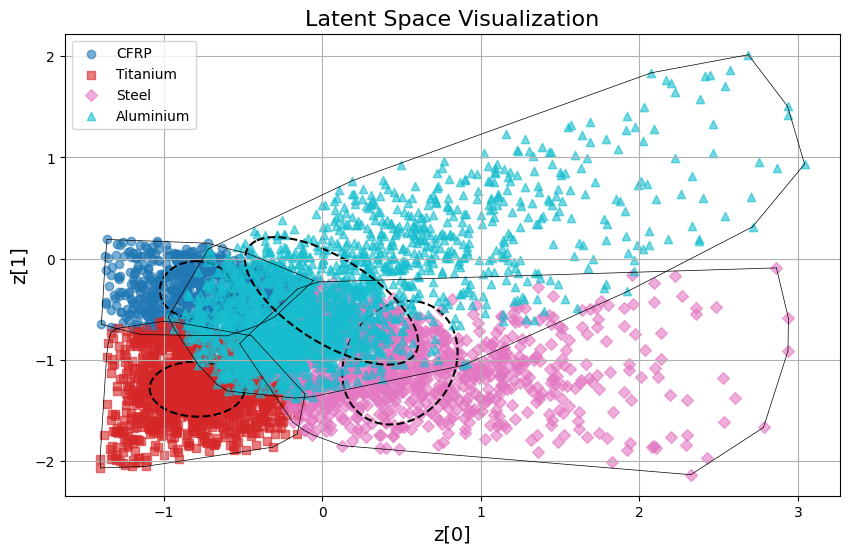

In [21]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def plotLatent(autoencoder, dataIdentifier, plotHull=False, plotEllipse=False, save_path='./figures/latent_space_plot.png'):
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    colorcol = dataIdentifier['classID'].to_numpy()

    class_ids = np.unique(colorcol)
    num_classes = len(class_ids)
    
    # Color and marker assignment
    clrs = cm.tab10(np.linspace(0, 1, num_classes))  # enough for 10 classes
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']
    
    plt.figure(figsize=(10, 6))

    for i, class_id in enumerate(class_ids):
        idxs = np.where(colorcol == class_id)[0]
        points = z[idxs, :]
        
        plt.scatter(points[:, 0], points[:, 1], c=[clrs[i]], marker=mrkrSet[i % len(mrkrSet)], label=dataIdentifier['family'][colorcol == class_id].iloc[0], alpha=0.6)

        if plotHull and len(points) >= 3:
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'k-', linewidth=0.5)

        if plotEllipse and len(points) > 1:
            cov = np.cov(points.T)
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(vals)
            mean = np.mean(points, axis=0)
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='k', fc='None', lw=1.5, ls='--')
            plt.gca().add_patch(ellipse)

    plt.xlabel('z[0]', fontsize=14)
    plt.ylabel('z[1]', fontsize=14)
    plt.title('Latent Space Visualization', fontsize=16)
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PNG file
    plt.savefig(save_path, format='png', dpi=300)  # Adjust dpi for higher resolution if needed

    # Optionally display the plot as well
    plt.show()

# Example usage:
plotLatent(materialEncoder.vaeNet, dataIdentifier, plotHull=True, plotEllipse=True, save_path='./figures/latent_space_plot.png')


The following contour plots aim to represent how the material properties change across the latent space. 

For this purpose, a 2D grid of fake latent points (X, Y) over the latent space is created over the latent space. A matrix Z will be defined with as many rows as latent points and as many columns as dimensions of the latent space. 

This function is designed for a 2D representation, therefore only 2 dimensions of the latent space will be picked (in our case our latent space is already 2 dimensional, so no choice of dimensions has to be done). 

Each grid point of Z is passed into the decoder, which will give us the predicted material properties for that point ("decoded_np"). Once we have our "real data" we will select the index of the material property of interest ("idx"), revert the scaling and obtain the real values (" prop_vals"). Finally, we just need to reshape these 1D vector into a 2D space.

Thanks to the decoder we match our fake grid points with the real valued material properties!



This function allows to specify:
-property_name: the property to visualize.
-ltnt1, ltnt2: the dimensions to choosn for the 2D plot. (In our case we only have 2 dimensions so 0 and 1 will be chosen but for higher order latent spaces, only 2 dimensions of interest can be chosen as this funciton works with a 2D grid).
-grid_size, zmin, zmax: grid resolution and range.

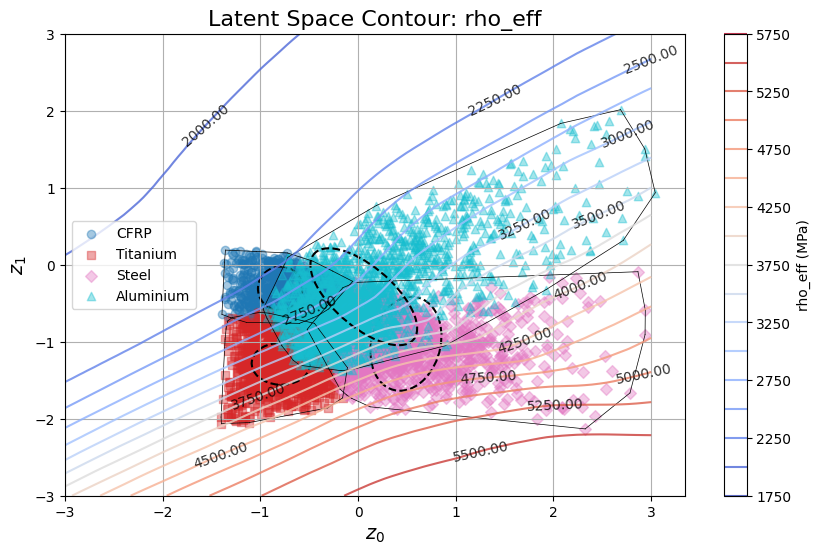

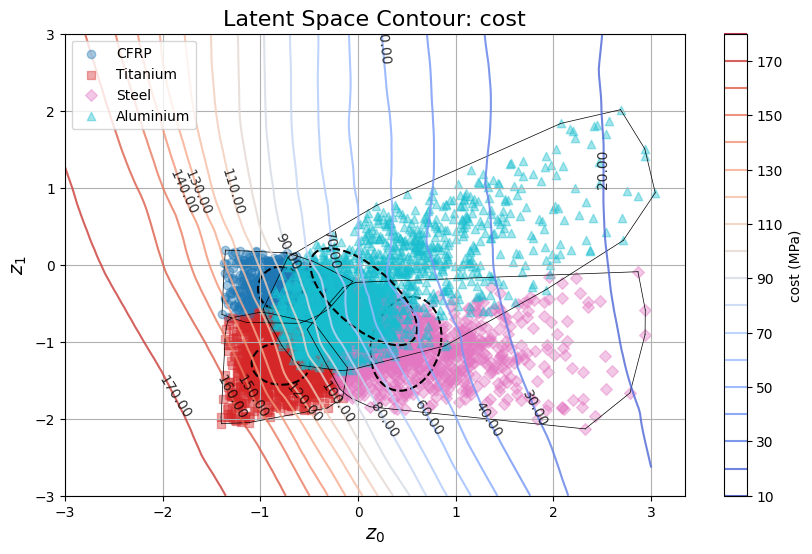

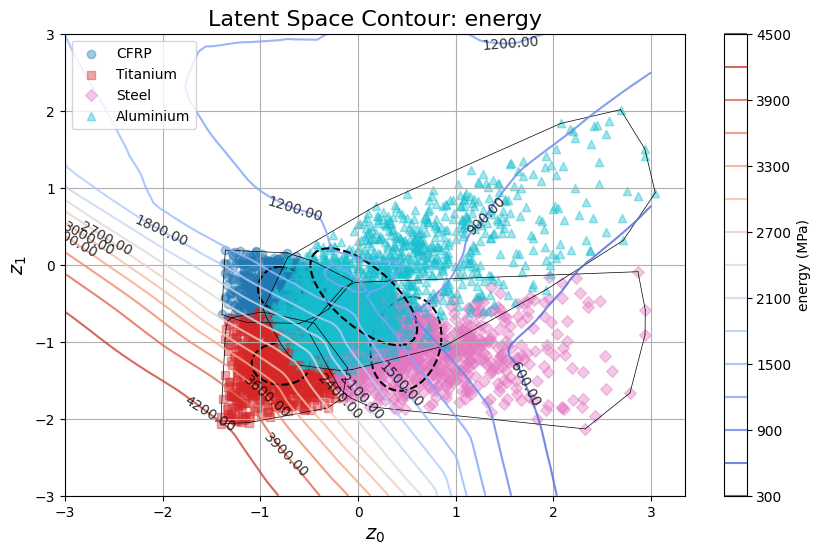

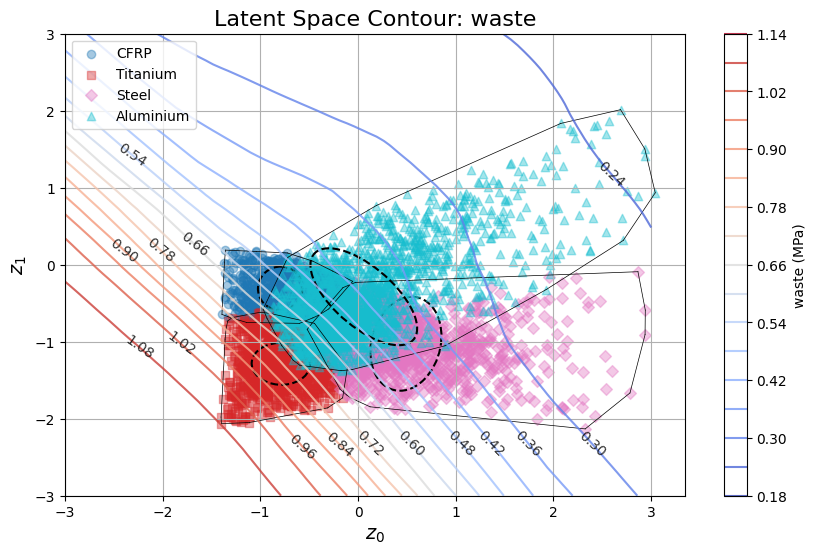

In [ ]:
def plotLatentProperty(autoencoder, dataInfo, property_name='rho_eff', ltnt1=0, ltnt2=1,
                       grid_size=80, zmin=-3, zmax=3, contour_levels=15,
                       plotHull=False, plotEllipse=True, save_path=None, show_plot=True):
    import matplotlib.pyplot as plt

    # Prepare latent grid
    X, Y = np.meshgrid(np.linspace(zmin, zmax, grid_size), np.linspace(zmin, zmax, grid_size))
    Z = torch.zeros((grid_size**2, autoencoder.encoder.z.shape[1])).to('cpu')
    Z[:, ltnt1], Z[:, ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

    # Decode
    with torch.no_grad():
        decoded = autoencoder.decoder(Z)
    decoded_np = to_np(decoded)

    # Property scaling
    idx = dataInfo[property_name]['idx']
    scaleMin = float(dataInfo[property_name]['scaleMin'])
    scaleMax = float(dataInfo[property_name]['scaleMax'])
    prop_vals = 10. ** (scaleMin + decoded_np[:, idx] * (scaleMax - scaleMin))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Optionally overlay latent points and families
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    colorcol = dataIdentifier['classID'].to_numpy()
    class_ids = np.unique(colorcol)
    clrs = cm.tab10(np.linspace(0, 1, len(class_ids)))
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']

    for i, class_id in enumerate(class_ids):
        idxs = np.where(colorcol == class_id)[0]
        points = z[idxs, :]
        ax.scatter(points[:, ltnt1], points[:, ltnt2], c=[clrs[i]], 
                   marker=mrkrSet[i % len(mrkrSet)], 
                   label=dataIdentifier['family'][colorcol == class_id].iloc[0], alpha=0.4)

        if plotHull and len(points) >= 3:
            hull = ConvexHull(points[:, [ltnt1, ltnt2]])
            for simplex in hull.simplices:
                ax.plot(points[simplex, ltnt1], points[simplex, ltnt2], 'k-', linewidth=0.5)

        if plotEllipse and len(points) > 1:
            cov = np.cov(points[:, [ltnt1, ltnt2]].T)
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(vals)
            mean = np.mean(points[:, [ltnt1, ltnt2]], axis=0)
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                              edgecolor='k', fc='None', lw=1.5, ls='--')
            ax.add_patch(ellipse)

    # Contour plot of the property
    prop_grid = prop_vals.reshape((grid_size, grid_size))
    contour = ax.contour(X, Y, prop_grid, levels=contour_levels, cmap='coolwarm', alpha=0.8)
    plt.clabel(contour, inline=False, fontsize=10, fmt='%0.2f', colors='black')
    cbar = plt.colorbar(contour)
    cbar.set_label(f'{property_name} (MPa)')

    ax.set_xlabel(f'$z_{ltnt1}$', fontsize=14)
    ax.set_ylabel(f'$z_{ltnt2}$', fontsize=14)
    ax.set_title(f'Latent Space Contour: {property_name}', fontsize=16)
    ax.legend()
    ax.grid(True)

    # Save and/or show
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    if show_plot:
        plt.show()
    else:
        plt.close()

plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='rho_eff',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/rho_eff_latentField.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='cost',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/cost_latentField.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='energy',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/energy_latentField.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='waste',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/waste_latentField.pdf'
)
